## **Прогнозирование оттока клиентов**

Компания хочет научиться прогнозировать отток клиентов. 

В нашем распоряжении персональные данные о некоторых клиентах.

**Цель проекта – обучить модель, которая будет предсказывать уход клиента**

**Задача проекта – обучить модель с метрикой AUC-ROC >= 0.85**

#### План проекта:   
1)	Изучим и обработаем данные   
    -)	Объединим таблицы по признаку «customerID»   
    -)  Заполним пропуски, скорректируем тип данных у признаков   
    -)  Создадим новый столбец, содержащий целевую переменную  
    -)	Посмотрим на уникальные значения признаков    
    -)	Посмотрим на дисбаланс классов    
    -)	Посмотрим на корреляцию признаков    
    -)  Проведем исследовательский анализ данных  
    -)  При необходимости удалим признаки   
2)	Подготовим данные для обучения модели     
    -)	Разобьем данные на обучающую и тестовую выборки   
    -)	Закодируем отдельные признаки (скорее всего, используем OHE)    
	
3)	Обучим несколько моделей с помощью кросс-валидации и найдем лучшую модель с помощью метрик AUC-ROC и accuracy. Добьемся значения AUC-ROC >= 0.85    
    -)  Проанализируем важность признаков 
4)	Проверим лучшую модель на тестовой выборке.


In [52]:
import pandas as pd
from pandas.plotting import scatter_matrix

import numpy as np
import datetime as dt

import phik
from phik import report
from phik.report import plot_correlation_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier 

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)



In [53]:
contract = pd.read_csv('contract.csv')

In [54]:
contract.info()
print()
print(contract.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

       MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000


In [55]:
internet = pd.read_csv('internet.csv')

In [56]:
internet.info()
print()
print(internet.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB

        customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     7590-VHVEG     Fiber optic             No           No   
freq             1            3096           3498         3088   

       DeviceProtection TechSupport StreamingTV StreamingMov

In [57]:
personal = pd.read_csv('personal.csv')

In [58]:
personal.info()
print()
print(personal.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

       SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000


In [59]:
phone = pd.read_csv('phone.csv')

In [60]:
phone.info()
print()
print(phone.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB

        customerID MultipleLines
count         6361          6361
unique        6361             2
top     5575-GNVDE            No
freq             1          3390


Проведя краткий обзор имеющихся данных, мы видим, что пропусков в данных нет, но количество объектов и признаков во всех таблицах разное, вследствие чего объединенная таблица будет содержать пропуски, которые необходимо будет заполнить. Также мы видим, что количество объектов в таблицах «contract» и «personal» одинаковое (7043 строки), что значит, скорее всего что у нас имеются данные о каждом клиенте, с которым заключен контракт. Есть неправильно указанный тип данных – признак «TotalCharges» в таблице «contract».

Начнем анализ с того, что посчитаем, сколько клиентов прекратило пользоваться услугами компании.

In [61]:
count_end = contract['EndDate'][contract['EndDate']!= 'No'].count()
print(count_end)

1869


Мы видим, что четверть из всех клиентов прекратила пользоваться услугами данного оператора. Кажется, что это достаточно отрицательный показатель. Возможно, стоит сравнить эти данные с данными других периодов и оценить этот показатель.

Для дальнейшего анализа объединим все таблицы.

In [62]:
contract_merge = contract.merge(internet, on='customerID', how='outer')
contract_merge = contract_merge.merge(personal, on='customerID', how='outer')
contract_merge = contract_merge.merge(phone, on='customerID', how='outer')

contract_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


Пропуски в столбцах InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies скорее всего вызваны тем, что клиент не пользуется интернет-услугами, поэтому эти пропуски мы можем заполнить значением 'No'. Пропуски в столбце "MultipleLines" заполним значением "no_user".

In [63]:
for i in contract_merge[['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
                        'StreamingMovies']]:
    contract_merge[i] = contract_merge[i].fillna('No')

In [64]:
contract_merge = contract_merge.fillna('no_user')

In [65]:
contract_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


Преобразуем признак "TotalCharges".

In [66]:
contract_merge['TotalCharges'] = pd.to_numeric(contract_merge['TotalCharges'], errors='coerce')

Посмотрим на пропуски этого признака.

In [67]:
fil = contract_merge[contract_merge['TotalCharges'].isna()]

Заменим пропуски в столбце "TotalCharges" на данные из столбца "MonthlyCharges". Из данных таблицы fil мы видим, что значений не хватает у клиентов, чья дата начала пользования услугами равна дате выгрузки данных. Поэтому мы можем заполнить эти столбцы одинаковыми значениями.

In [68]:
fil = contract_merge[contract_merge['TotalCharges'].isna()]
for i in fil.index:
    contract_merge.loc[i, 'TotalCharges'] = contract_merge.loc[i, 'MonthlyCharges']

И, наконец, изменим тип признака.

In [69]:
contract_merge['TotalCharges'] = contract_merge['TotalCharges'].astype('float')

Добавим новый столбец "Out", в котором создадим целевой признак. Целевой признак взят из столбца "EndDate". Объекты, в которых указана дата окончания пользования услугами компании, получат целевой признак = 1, остальные будут равны 0.

In [70]:
contract_merge['Out'] = 1
contract_merge.loc[contract_merge['EndDate'] == 'No', 'Out'] = 0

Посмотрим на уникальные значения в некоторых столбцах.

In [71]:
uniq = ['Type', 'PaymentMethod', 'InternetService']
for i in uniq:
    print(contract_merge[i].unique())

['Month-to-month' 'One year' 'Two year']
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
['DSL' 'Fiber optic' 'No']


Мы видим, что тип оплаты бывает 3-х видов: Month-to-month, One year, Two year. Способ оплаты делится на: Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic). Интернет-подключение может быть двух видов: DSL, Fiber optic и также есть тип "No". Значения "No" мы вставили вместо пропущенных значений. 

In [72]:
print(contract_merge.duplicated().sum())

0


Явных дубликатов в данных нет.

Теперь посмотрим, как данные связаны между собой. Для начала построим корреляционную матрицу.

In [73]:
contr_phik = contract_merge.phik_matrix()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Out']


Построим график.

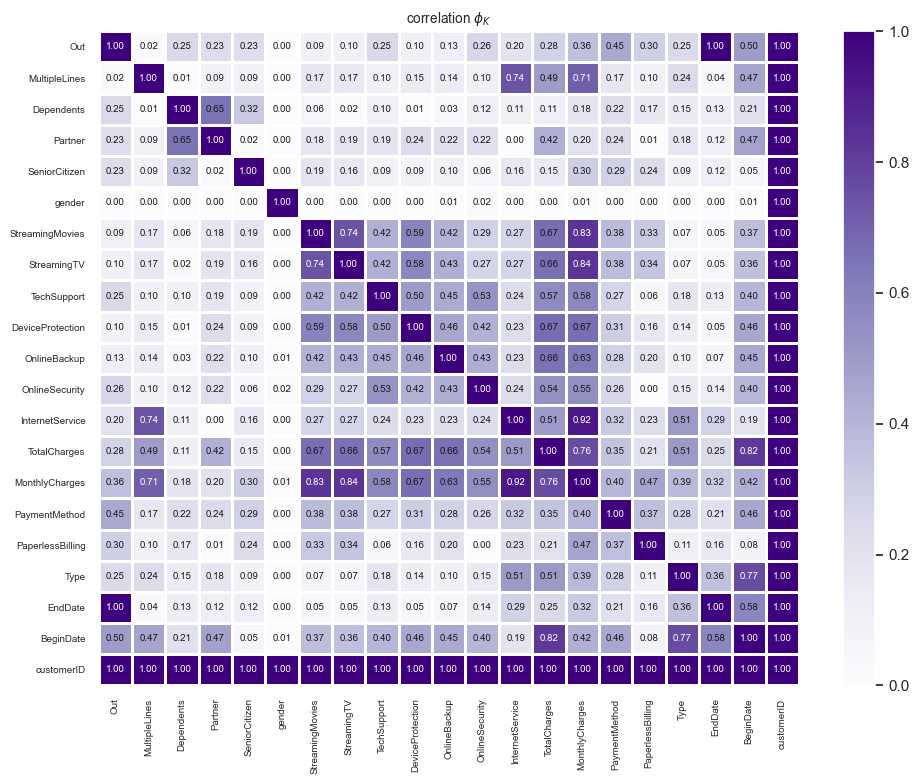

In [74]:
plot_correlation_matrix(contr_phik.values, 
                        x_labels=contr_phik.columns, 
                        y_labels=contr_phik.index, 
                        vmin=0, vmax=1, color_map="Purples", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.7, 
                        figsize=(10, 8))
plt.tight_layout()

Что вполне логично - признаки "EndDate" и "Out" имеют высокую корреляцию, т.к. один признак сгенерирован на основе другого. Перед обучением моделей необходимо будет удалить признак "EndDate". При этом, возможно, на целевую переменную влияет количество времени, в течение которого клиент уже пользуется услугами компании. Чтобы не потерять возможно значимый признак, создадим новый на основе признаков "BeginDate" и "EndDate", который будет содержать разницу между вторым и первым.

In [75]:
contract_merge['BeginDate'] = pd.to_datetime(contract_merge['BeginDate'], format='%Y.%m.%d')
contract_merge['EndDateNew'] = contract_merge['EndDate'].replace('No', '2020-02-01 00:00:00')
contract_merge['EndDateNew'] = pd.to_datetime(contract_merge['EndDateNew'], format='%Y.%m.%d')

In [76]:
contract_merge['Time'] = (contract_merge['EndDateNew'] - contract_merge['BeginDate']).dt.days

Новый признак "Time" создан на основе столбцов "BeginDate" и "EndDate", поэтому оставляя в таблице один из этих признаков вместе с новым "Time", мы даем возможность модели "подсмотреть" третий, поэтому удалим при формировании выборок оба признака ("BeginDate" и "EndDate").

У нас появился новый признак, попробуем посмотреть на корреляцию ещё раз.

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Out', 'Time']


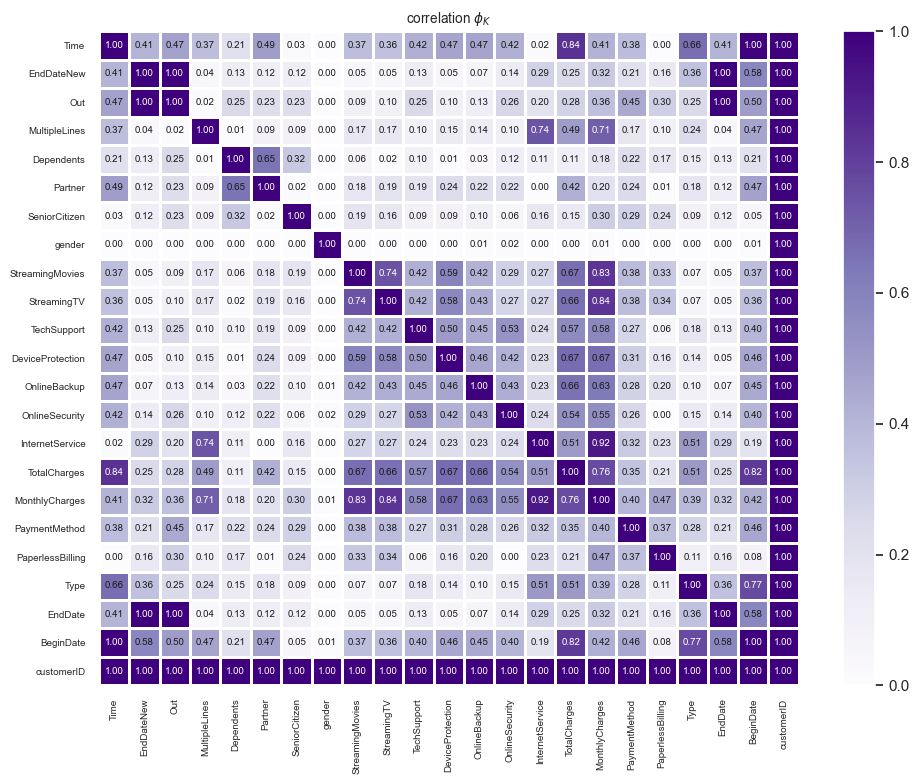

In [77]:
contr_phik = contract_merge.phik_matrix()
plot_correlation_matrix(contr_phik.values, 
                        x_labels=contr_phik.columns, 
                        y_labels=contr_phik.index, 
                        vmin=0, vmax=1, color_map="Purples", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.7, 
                        figsize=(10, 8))
plt.tight_layout()

Мы видим, что у нового столбца "Time" высокая корреляция со столбцом "TotalCharges", что логично, т.к. чем дольше клиент пользуется услугами компании, тем больше средств он уже потратил, а значит - мы можем удалить лишний признак. Признак "Time" имеет самое большое из всех признаков влияние на целевой признак. Посмотрим, как количество времени, в течение которого клиент пользуется услугами компании влияет на целевую переменную.

<Axes: xlabel='Out', ylabel='Time'>

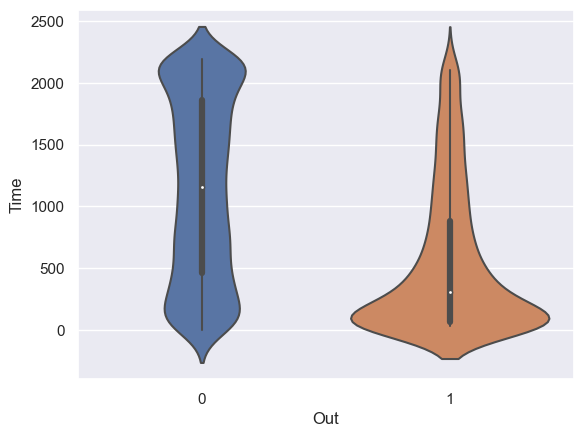

In [78]:

sns.violinplot(x=contract_merge["Out"], y=contract_merge["Time"])

Мы видим на оранжевом графике, что чем дольше клиент пользуется услугами компании, тем меньше вероятность его ухода и наоборот - значительная часть ушедших клиентов среди тех, кто пользовался услугами менее 500 дней. Здесь можно использовать информацию в двух направлениях: возможно, стоит сосредоточиться на удержании клиентов дольше 500 дней (возможно, свыше 500 у клиента наступает "привыкание", поэтому доля ушедших клиентов ниже после этого периода) или сосредоточиться на удержании постоянных клиентов (тех, кто пользуется услугами больше 500 дней) и привлечении новых клиентов (возможно, что 500 дней - это некая кризисная точка, на которой определяется - будет клиент постоянным или уйдет).

Также мы видим, что у столбца "Out" высокая корреляция со столбцом "PaymentMethod". Посмотрим, как коррелируются эти два признака.

<Axes: xlabel='Out', ylabel='PaymentMethod'>

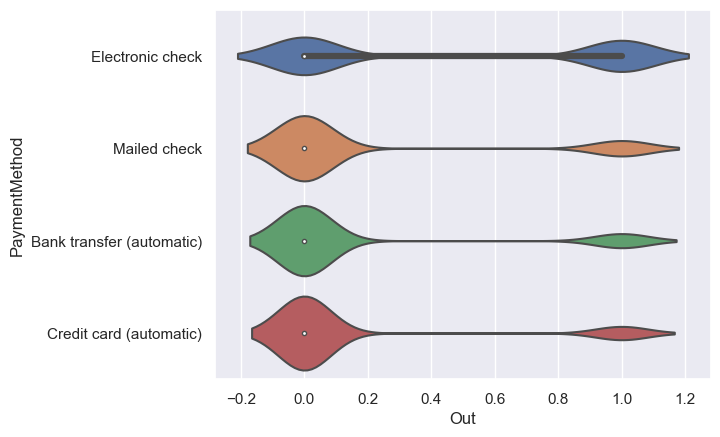

In [79]:
sns.violinplot(x=contract_merge["Out"], y=contract_merge["PaymentMethod"])

Мы видим, что среди клиентов, которые пользуются способами оплаты: Mailed check, Bank transfer (automatic), Credit card (automatic), доля ушедших клиентов гораздо меньше доли оставшихся клиентов. А вот среди клиентов, которые пользуются способом оплаты Electronic check доля ушедших клиентов примерно равна доле оставшихся. Возможно, стоит проанализировать этот способ оплаты на возможные проблемы/неудобства для клиентов.

Высокая мультиколлинеарность между признаками InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies объясняется тем, что в первоначальной таблице "internet" данных было почти на 1500 меньше, чем в сводной таблице и пропуски мы заполнили значением-заглушкой, а значит - признаки получились одинаковыми почти на 1/5. К тому же все они не могут существовать без признака InternetService. Удалим все эти признаки перед делением выборки на обучающую и тестовую, оставив только один из них - InternetService. Также мы видим высокую коллинеарность названных признаков с признаком MonthlyCharges, что, в целом, объяснимо, т.к. подключение интернета и связанных с ним услуг скорее всего увеличивают стоимость услуг в месяц. Попробуем посмотреть на связь этих признаков.

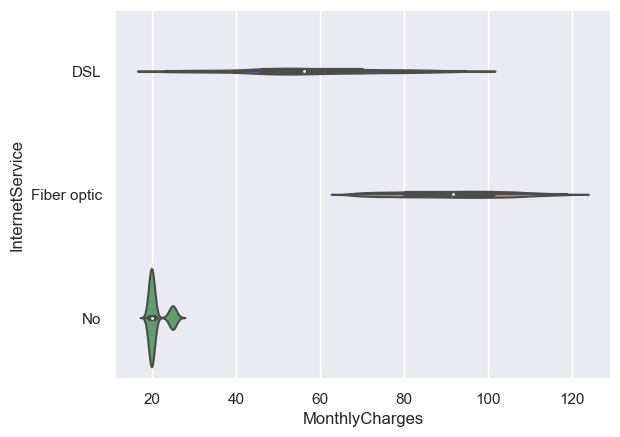

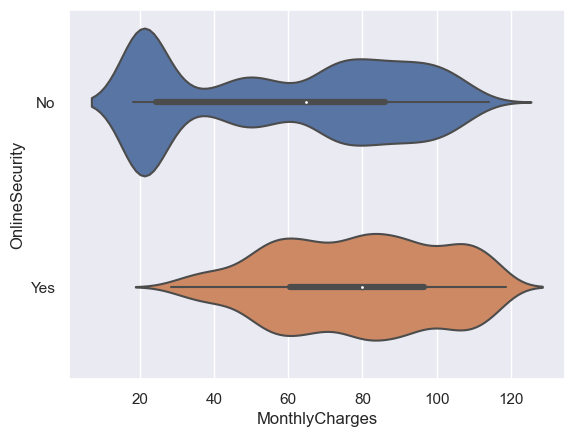

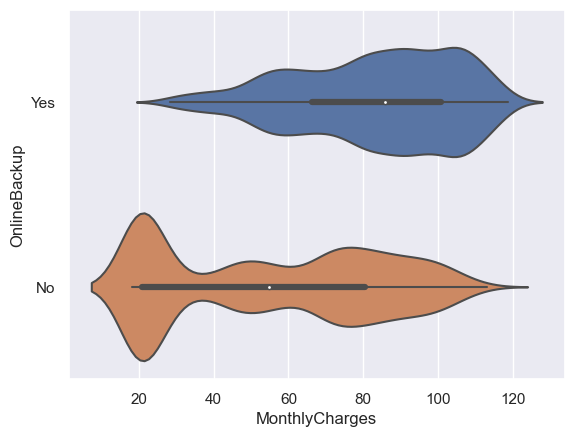

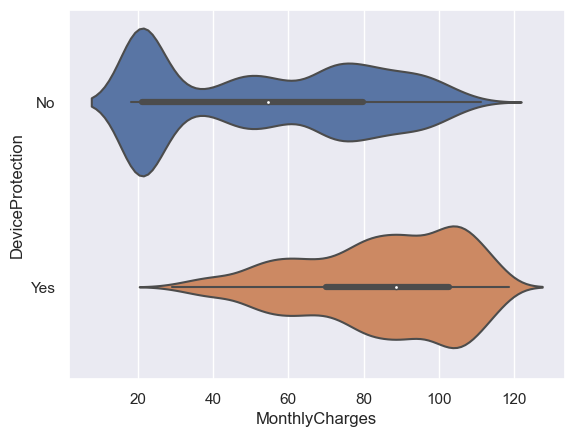

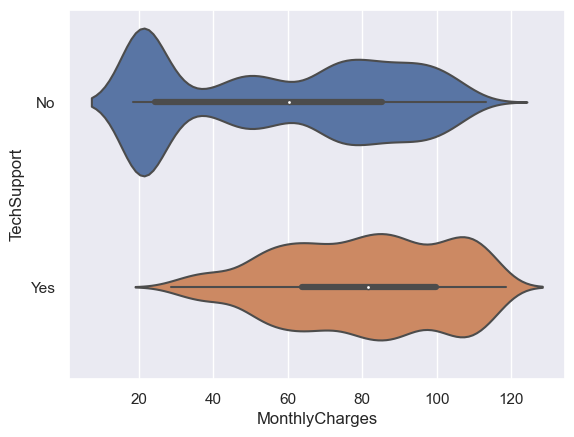

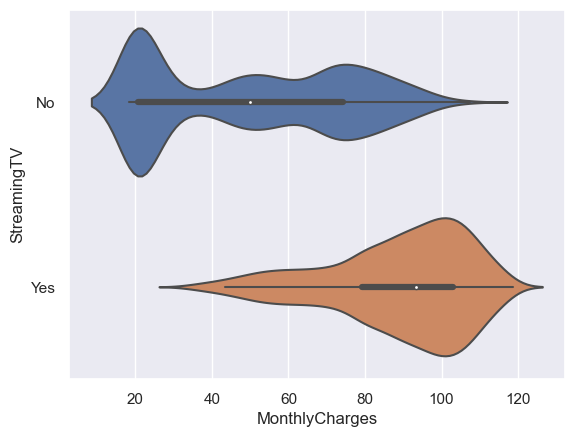

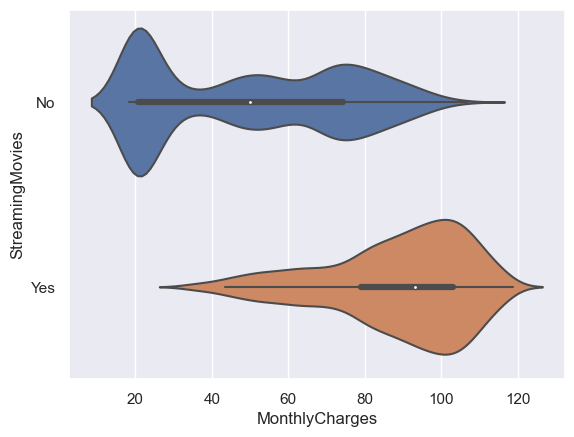

In [80]:
for i in ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    plt.figure()
    sns.violinplot(x=contract_merge["MonthlyCharges"], y=contract_merge[i])


Из графиков видно, что пользователи, которые не пользуются интернет-услугой и сопутствующими сервисами платят за месяц не более 30 денежных единиц. Из первого графика видно, что fiber_optic дороже DSL.

Также наблюдается связь типа оплаты (признак "Type") и интернет-услуг. Посмотрим, какие типы оплаты предпочитают пользователи, пользующиеся интернет-услугами.

In [81]:
type_int = contract_merge['Type'][contract_merge['InternetService'] !='No']
type_notint = contract_merge['Type'][contract_merge['InternetService'] =='No']

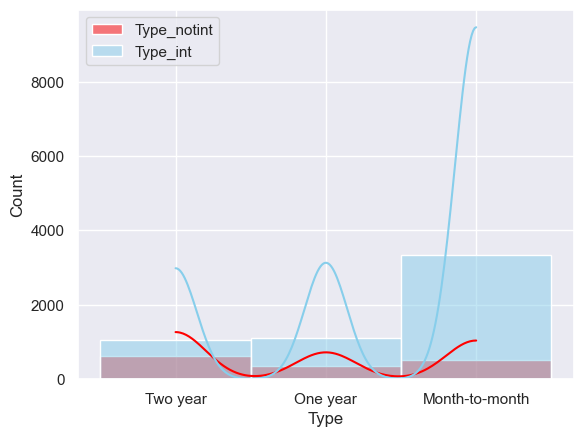

In [82]:
sns.set(style="darkgrid")
sns.histplot(data=type_notint, x=type_notint, color="red", label="Type_notint", kde=True)
sns.histplot(data=type_int, x=type_int, color="skyblue", label="Type_int", kde=True)

plt.legend() 
plt.show()

Мы видим, что пользователи интернет-услуг (Type_int) предпочитают помесячную оплату, в то время те, кто не пользуется этими услугами (Type_notint) пользуются примерно одинаково всеми тремя типами оплаты, немного больше выделяя способ "Two year". Возможно, это связано с гораздо более высокими расходами на интернет (как мы выяснили ранее, стоимость интернет услуг делает ежемесячную оплату выше).

In [83]:
contract_merge['Out'].value_counts()

0    5174
1    1869
Name: Out, dtype: int64

Видим, что нулевых значений почти в 3 раза больше. Это явный дисбаланс классов. Пока оставим данные в исходном состоянии, но будем учитывать этот факт при работе с моделями. Возможно, при обучении моделей, мы сможем использовать параметры самой модели для балансировки классов без изменения исходной выборки. Тем более, для оценки качества, мы будем использовать метрику ROC_AUC, которая не особо чувствительна к дисбалансу данных.

Перед разделением выборки на обучающую и тестовую удалим необходимые столбцы.

In [84]:
contract_merge = contract_merge.drop(
    columns=['customerID', 'BeginDate', 'EndDate', 'TotalCharges', 
             'EndDateNew', 'gender', 'OnlineSecurity', 'OnlineBackup', 
             'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'], axis=1)


Помимо удаления запланированных столбцов, мы удалим также признак "gender", т.к. у него практически нулевая корреляция со всеми признаками.

Далее разделим датафрейм на выборки.

In [85]:
target = contract_merge['Out']
features = contract_merge.drop('Out', axis=1)

features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            random_state = 270223, 
                                                                           test_size = 0.25, shuffle=True, stratify=target)

Закодируем категориальные признаки.

In [86]:
features_train = pd.get_dummies(features_train, drop_first=True)
features_test = pd.get_dummies(features_test, drop_first=True)
features_train.columns == features_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

Начнем обучение с модели случайного леса.

In [87]:
pipe_forest = Pipeline([
      ('scale', StandardScaler()),
      ('model', RandomForestClassifier(random_state=270223, class_weight='balanced_subsample'))
])
param_grid = {'model__n_estimators': (3, 5, 8, 10, 13),
              'model__max_depth': [1, 2, 5, 7]}
scoring = ['roc_auc', 'accuracy']
search_forest = GridSearchCV(pipe_forest, param_grid, cv=7, scoring=scoring, refit='roc_auc', 
                             return_train_score=True).fit(features_train, target_train)

In [88]:
print(search_forest.best_score_)
print(search_forest.best_params_)

0.8431211612997
{'model__max_depth': 7, 'model__n_estimators': 13}


In [89]:
res_forest = pd.DataFrame(search_forest.cv_results_)
display(res_forest[['mean_test_roc_auc', 'mean_test_accuracy']])

,mean_test_roc_auc,mean_test_accuracy
0,0.740264,0.675305
1,0.732039,0.677584
2,0.734544,0.674735
3,0.750597,0.685909
4,0.764387,0.688751
5,0.790594,0.728310
6,0.817337,0.746488
7,0.819890,0.740432
8,0.818032,0.741754
9,0.816709,0.738346


Лучшая метрика ROC-AUC у модели Случайного леса равна 0.85, метрика Accuracy равна 0.76. 
Лучшие параметры: max_depth - 7, n_estimators - 13

Теперь обучим модель логистической регрессии. 

In [90]:
pipe_reg = Pipeline([
      ('scale', StandardScaler()),
      ('model', LogisticRegression(random_state=270223, solver='lbfgs', class_weight='balanced'))
])
param_grid = {'model__max_iter': (500, 700, 1000, 1300)}
scoring = ['roc_auc', 'accuracy']
search_reg = GridSearchCV(pipe_reg, param_grid, cv=7, scoring=scoring, refit='roc_auc', 
                             return_train_score=True).fit(features_train, target_train)

In [91]:
print(search_reg.best_score_)
print(search_reg.best_params_)

0.8399136391901357
{'model__max_iter': 500}


In [92]:
res_reg = pd.DataFrame(search_reg.cv_results_)
display(res_reg[['mean_test_roc_auc', 'mean_test_accuracy']])

,mean_test_roc_auc,mean_test_accuracy
0,0.839914,0.74214
1,0.839914,0.74214
2,0.839914,0.74214
3,0.839914,0.74214


Лучшая метрика ROC-AUC у модели логистической регрессии равна 0.84, метрика Accuracy равна 0.75. 
Лучшие параметры: max_iter - 500.

Попробуем теперь обучить модель градиентного бустинга. Воспользуемся библиотекой CatBoost.

In [93]:
pipe_cat = Pipeline([
      ('model', CatBoostClassifier(loss_function="Logloss", random_state=270223, grow_policy='Lossguide', auto_class_weights='Balanced', silent=True))
])
param_grid = {'model__iterations': (200, 400, 600),
              'model__depth': (5, 8, 11),
              'model__min_data_in_leaf': (5, 15, 28)}
scoring = ['roc_auc', 'accuracy']
search_cat = GridSearchCV(pipe_cat, param_grid, cv=3, scoring=scoring, refit='roc_auc', 
                             return_train_score=True).fit(features_train, target_train)

In [94]:
print(search_cat.best_score_)
print(search_cat.best_params_)

0.9121464485470933
{'model__depth': 11, 'model__iterations': 400, 'model__min_data_in_leaf': 28}


In [95]:
res_cat = pd.DataFrame(search_cat.cv_results_)
display(res_cat[['mean_test_roc_auc', 'mean_test_accuracy']])

,mean_test_roc_auc,mean_test_accuracy
0,0.898822,0.829611
1,0.898860,0.825068
2,0.899380,0.824498
3,0.902333,0.833019
4,0.900739,0.835480
5,0.904884,0.838132
6,0.902516,0.834913
7,0.902102,0.835291
8,0.903662,0.831882
9,0.905515,0.849112


Лучшая метрика ROC-AUC у модели CatBoost равна 0.90, метрика Accuracy равна 0.85. 
Лучшие параметры: depth - 11, iterations - 400, min_data_in_leaf - 28.

Воспользуемся библиотекой Light GBM.

In [96]:
pipe_lg = Pipeline([
      ('model', LGBMClassifier(random_state=270223, class_weight='balanced'))
])
param_grid = {'model__n_estimators': (3, 5, 7, 10, 15)}
scoring = ['roc_auc', 'accuracy']
search_lg = GridSearchCV(pipe_lg, param_grid, cv=7, scoring=scoring, refit='roc_auc', 
                             return_train_score=True).fit(features_train, target_train)

In [97]:
print(search_lg.best_score_)
print(search_lg.best_params_)

0.863719310820138
{'model__n_estimators': 15}


In [98]:
res_lg = pd.DataFrame(search_lg.cv_results_)
display(res_lg[['mean_test_roc_auc', 'mean_test_accuracy']])

,mean_test_roc_auc,mean_test_accuracy
0,0.849823,0.759183
1,0.853046,0.760696
2,0.854103,0.766752
3,0.858102,0.773759
4,0.863719,0.780951


Лучшая метрика ROC-AUC у модели LGBMClassifier равна 0.87, метрика Accuracy равна 0.78. 
Лучшие параметры: n_estimators - 15.

Соберем данные всех метрик в одну таблицу.

In [99]:
total = {'Название модели': ['RandomForestClassifier', 'LogisticRegression', 'CatBoostClassifier', 'LGBMClassifier'], 
          'ROC-AUC': [res_forest.loc[19, 'mean_test_roc_auc'], res_reg.loc[3, 'mean_test_roc_auc'], res_cat.loc[4, 'mean_test_roc_auc'], 
                      res_lg.loc[4, 'mean_test_roc_auc']],
          'Метрика': [res_forest.loc[19, 'mean_test_accuracy'], res_reg.loc[3, 'mean_test_accuracy'], res_cat.loc[4, 'mean_test_accuracy'], 
                      res_lg.loc[4, 'mean_test_accuracy']]}
best = pd.DataFrame(total)
display(best)

,Название модели,ROC-AUC,Метрика
0,RandomForestClassifier,0.843121,0.759935
1,LogisticRegression,0.839914,0.742140
2,CatBoostClassifier,0.900739,0.835480
3,LGBMClassifier,0.863719,0.780951


Лучшие показатели метрик у модели CatBoostClassifier, значит для тестовой выборки используем данную модель с лучшими параметрами: depth - 11, iterations - 400, min_data_in_leaf - 28.

In [100]:
model = CatBoostClassifier(loss_function="Logloss", depth=11, iterations=400, random_state=270223, grow_policy='Lossguide', min_data_in_leaf=28,
                           auto_class_weights='Balanced', silent=True)
model.fit(features_train, target_train)

probabilities_test = model.predict_proba(features_test)[:, 1]
print(roc_auc_score(target_test, probabilities_test).round(2))

probabilities_test2 = model.predict(features_test)
print(accuracy_score(target_test, probabilities_test2).round(2))

0.93
0.87


<Figure size 640x480 with 0 Axes>

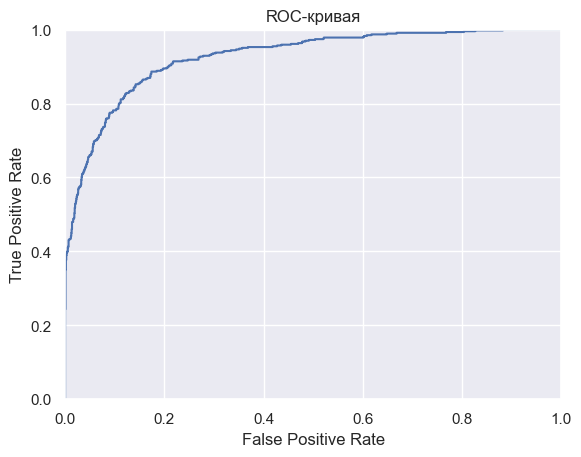

In [101]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_test)  # < напишите код здесь >

plt.figure()
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

Значение ROC-AUC = 0.93, метрика Accuracy равна 0.87. Поставленная задача выполнена.

Посмотрим, какие признаки больше появлияли на обучение модели.

Label             : Importance
--------------------------
              Time: 6253.77%
    MonthlyCharges: 1245.25%
     Type_Two year: 807.31%
InternetService_Fiber optic: 331.95%
     Type_One year: 236.70%
PaymentMethod_Electronic check: 230.87%
InternetService_No: 179.72%
    Dependents_Yes: 141.75%
PaperlessBilling_Yes: 115.61%
     SeniorCitizen: 95.12%
 MultipleLines_Yes: 91.01%
PaymentMethod_Mailed check: 86.66%
       Partner_Yes: 67.30%
PaymentMethod_Credit card (automatic): 67.24%
MultipleLines_no_user: 49.74%


<Axes: xlabel='importance', ylabel='feature'>

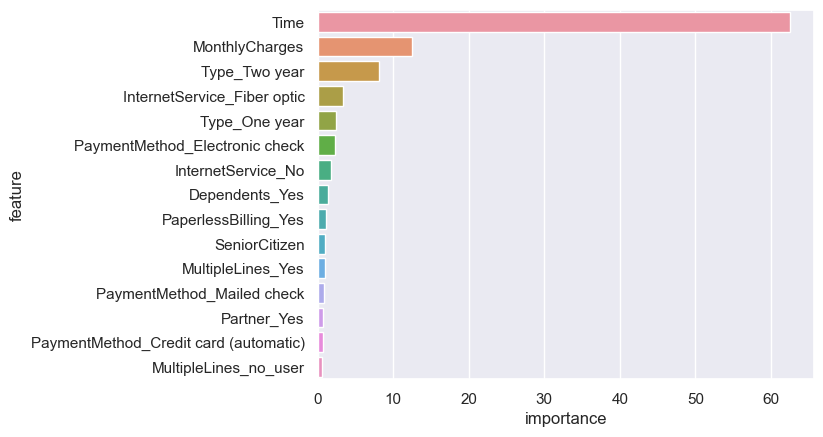

In [102]:
model.fit(features_train, target_train)
print(f'{"Label":18s}: Importance')
print(26*'-')
for val, name in sorted(zip(model.feature_importances_, features_train.columns),key=lambda x: x[0], reverse=True):
    print(f'{name:>18}: {val:.2%}')

signs = pd.DataFrame(
    {
    'feature': features_train.columns,
    'importance': model.feature_importances_,
    }
).sort_values(
    by = 'importance', 
    ascending = False,
)

sns.barplot(x = signs['importance'], y = signs['feature'])

Как можно увидеть из данных выше, наиболее важным при обучении модели оказался признак Time.

Мы проанализировали данные и обучили модели. Лучшей оказалась модель CatBoostClassifier с AUC-ROC = 0.93

# **Вывод**

Провели **анализ исходных данных**:  

-) Увидели, что *четверть из всех клиентов прекратила пользоваться услугами компании.* Возможно, стоит сравнить эти данные с данными других периодов и оценить этот показатель.  
-) Также видим, что *чем дольше клиент пользуется услугами компании, тем меньше вероятность его ухода* и наоборот - значительная часть ушедших клиентов среди тех, кто пользовался услугами менее 500 дней.  
-) Возможно, *стоит проанализировать способ оплаты Electronic check на возможные проблемы/неудобства для клиентов*, т.к. среди клиентов, которые пользуются способами оплаты: Mailed check, Bank transfer (automatic), Credit card (automatic), доля ушедших клиентов гораздо меньше доли оставшихся клиентов. А вот среди клиентов, которые пользуются способом оплаты Electronic check доля ушедших клиентов примерно равна доле оставшихся.   
-) *Пользователи интернет-услуг предпочитают помесячную оплату*, в то время как те, кто не пользуется этими услугами пользуются примерно одинаково всеми тремя типами оплаты, немного больше выделяя способ "Two year". Возможно, это связано с гораздо более высокими расходами на интернет (как мы выяснили ранее, стоимость интернет-услуг делает ежемесячную оплату выше).

Перед обучением модели мы выполнили **предобработку данных**:  

-) объединили таблицы по столбцу "customerID"  
-) заполнили пропуски   
-) изменили тип данных столбца "TotalCharges"  
-) убедились в отсутствии явных дубликатов  
-) добавили новый столбец, содержащий целевую переменную  
-) добавили новый столбец "Time", содержащий разницу между "EndDateNew" и "BeginDate"  
-) удалили необходимые столбцы  
-) разделили данные на выборки  
-) закодировали категориальные признаки


**Обучили несколько моделей:**
1) *RandomForestClassifier*   
Параметры: random_state=270223, class_weight='balanced_subsample', n_estimators: (3, 5, 8, 10, 13), max_depth: (1, 2, 5, 7)

2) *LogisticRegression*  
Параметры: random_state=270223, solver='lbfgs', class_weight='balanced_subsample', max_iter: (500, 700, 1000, 1300)

3) *CatBoostClassifier*  
Параметры: loss_function="Logloss", random_state=270223, grow_policy='Lossguide', auto_class_weights='Balanced', iterations: (200, 400, 600), depth: (5, 8, 11), min_data_in_leaf: (5, 15, 28)

4) *LGBMClassifier*  
Признаки: random_state=270223, class_weight='balanced', n_estimators: (3, 5, 7, 10, 15)

***Лучшей оказалась модель CatBoostClassifier с AUC-ROC = 0.93***  

*Наиболее важным при обучении модели оказался признак Time.*